===============train-labels===============
magic number: 2049
item num: 60000
===============train-images===============
magic number: 2051
item num: 60000, 28 row * 28 col
5.0


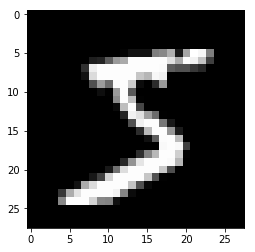

In [3]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def parse_idx3(path):
    # read bin data from file
    bin_data = open(path, 'rb').read()

    # parse head info
    offset = 0
    # read first 4 line
    format_head = '>iiii'
    magic_number, item_num, row_num, col_num = struct.unpack_from(format_head, bin_data, offset)
    # show magic number and dimensions size
    file_name = path.split('/')[-1].split('.')[0]
    print(('='*15) + file_name + ('='*15))
    print('magic number: %d' % magic_number)
    print('item num: %d, %d row * %d col' % (item_num, row_num, col_num))
    print('=' * (30 + len(file_name)))

    # parse data
    item_size = row_num * col_num
    # read one item once
    format_data = '>' + str(item_size) + 'B'
    # set offest to where we have finished reading
    offset = struct.calcsize(format_head)
    # create an empty array and fill it
    items = np.empty((item_num, row_num, col_num))
    for i in range(item_num):
        items[i] = np.array(struct.unpack_from(format_data, bin_data, offset)).reshape((row_num, col_num))
        offset = offset + struct.calcsize(format_data)
    return items

# same as parse_idx3
def parse_idx1(path):
    bin_data = open(path, 'rb').read()
    offset = 0
    format_head = '>ii'
    magic_number, item_num = struct.unpack_from(format_head, bin_data, offset)
    file_name = path.split('/')[-1].split('.')[0]
    print(('='*15) + file_name + ('='*15))
    print('magic number: %d' % magic_number)
    print('item num: %d' % item_num)
    print('=' * (30 + len(file_name)))
    format_data = '>B'
    offset = struct.calcsize(format_head)
    items = np.empty(item_num)
    for i in range(item_num):
        items[i] = struct.unpack_from(format_data, bin_data, offset)[0]
        offset = offset + struct.calcsize(format_data)
    return items


train_labels_path = 'D:/MY/ml-data/handwritting-recognition/train-labels.idx1-ubyte'
train_images_path = 'D:/MY/ml-data/handwritting-recognition/train-images.idx3-ubyte'

# show first label and image
train_labels = parse_idx1(train_labels_path)
train_images = parse_idx3(train_images_path)
print(train_labels[0])
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [4]:
from keras.utils import to_categorical

# read from file
train_labels_path = 'D:/MY/ml-data/handwritting-recognition/train-labels.idx1-ubyte'
train_images_path = 'D:/MY/ml-data/handwritting-recognition/train-images.idx3-ubyte'
train_labels = parse_idx1(train_labels_path)
train_images = parse_idx3(train_images_path)

# change 0~9 => row vector only contains 0/1
print(train_labels)
train_labels = to_categorical(train_labels, 10)
print(train_labels)
# change 28x28 => 1x28x28
print(train_images)
train_images = train_images.reshape(-1, 28, 28, 1)
print(train_images)
# change type to float32
train_images = train_images.astype('float32')
train_images /= 255

# load test data
test_labels_path = 'D:/MY/ml-data/handwritting-recognition/t10k-labels.idx1-ubyte'
test_images_path = 'D:/MY/ml-data/handwritting-recognition/t10k-images.idx3-ubyte'
# same as before
test_labels = parse_idx1(test_labels_path)
test_images = parse_idx3(test_images_path)
test_images = test_images.reshape(-1, 28, 28, 1)
test_images = test_images.astype('float32')
test_images /= 255
test_labels = to_categorical(test_labels, 10)

===============train-labels===============
magic number: 2049
item num: 60000
===============train-images===============
magic number: 2051
item num: 60000, 28 row * 28 col
[5. 0. 4. ... 5. 6. 8.]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. .

In [20]:
# build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

model = Sequential()
# Conv Layer
model.add(Conv2D(32, (5,5), activation='relu', input_shape=[28, 28, 1]))
model.add(Conv2D(64, (5,5), activation='relu'))
# Pool Layer
model.add(MaxPool2D(pool_size=(2,2)))
# Flatten Layer
model.add(Flatten())
# Dropout Layer
model.add(Dropout(0.5))
# Dense Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# compile model (set loss and optimize func)
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['accuracy'])

# data num in one batch
batch_size = 80
# times to cover all training data
epochs = 16
# start training
model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs)

# test accuracy
loss, accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('loss: %.4f accuracy: %.4f' %(loss, accuracy))

Epoch 1/16
60000/60000 [==============================] - 15s 253us/step - loss: 0.2059 - acc: 0.9364
Epoch 2/16
60000/60000 [==============================] - 14s 236us/step - loss: 0.0791 - acc: 0.9767
Epoch 3/16
60000/60000 [==============================] - 14s 236us/step - loss: 0.0613 - acc: 0.9815
Epoch 4/16
60000/60000 [==============================] - 14s 237us/step - loss: 0.0513 - acc: 0.9841
Epoch 5/16
60000/60000 [==============================] - 14s 236us/step - loss: 0.0438 - acc: 0.9873
Epoch 6/16
60000/60000 [==============================] - 14s 237us/step - loss: 0.0411 - acc: 0.9877
Epoch 7/16
60000/60000 [==============================] - 14s 236us/step - loss: 0.0357 - acc: 0.9892
Epoch 8/16
60000/60000 [==============================] - 14s 236us/step - loss: 0.0355 - acc: 0.9896
Epoch 9/16
60000/60000 [==============================] - 14s 235us/step - loss: 0.0334 - acc: 0.9903
Epoch 10/16
60000/60000 [==============================] - 14s 235us/step - loss: 